In [1]:
import sys
import os
import json
sys.path.append("../")
from scipy import integrate
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d
import obspy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import source_wavelet,set_damp,dictToObj,numpy2tensor,numpy2list,list2numpy
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.gradient_precond import grad_precond
from TorchInversion.optimizer import Optimization

### model setup

In [2]:
save_path = "./data/04_Marmousi2/AD_shotInMiddle"

if not os.path.exists(os.path.join(save_path,"model/Initial")):
    os.makedirs(os.path.join(save_path,"model/Initial"))

if not os.path.exists(os.path.join(save_path,"grad")):
    os.makedirs(os.path.join(save_path,"grad"))

if not os.path.exists(os.path.join(save_path,"obs/figure")):
    os.makedirs(os.path.join(save_path,"obs/figure"))

if not os.path.exists(os.path.join(save_path,"syn/figure")):
    os.makedirs(os.path.join(save_path,"syn/figure"))
    
if not os.path.exists(os.path.join(save_path,"inv/model")):
    os.makedirs(os.path.join(save_path,"inv/model"))
    
if not os.path.exists(os.path.join(save_path,"inv/grad")):
    os.makedirs(os.path.join(save_path,"inv/grad"))

In [3]:
#######################################
#              模型设置
#######################################
# Model parameters
nx , ny = [80, 179]
nt , dt = [1545, 0.00317]
pml, fs   = [15,  1]
nx_pml = nx+2*pml
ny_pml = ny+2*pml
dx, dy = [44.7619, 44.1679]

In [4]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)


def load_marmousi_model():
    in_dir = os.path.join(save_path,"model/True/")
    if not os.path.exists(os.path.join(in_dir, "vp_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vp_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "vs_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/vs_marmousi-ii.segy.gz", in_dir))
    if not os.path.exists(os.path.join(in_dir, "density_marmousi-ii.segy.gz")):
        os.system("wget {} -P {}".format("http://www.agl.uh.edu/downloads/density_marmousi-ii.segy.gz", in_dir))
    meta = obspy.read(os.path.join(in_dir, "vs_marmousi-ii.segy.gz"), format='segy')
    vs = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "vp_marmousi-ii.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    meta = obspy.read(os.path.join(in_dir, "density_marmousi-ii.segy.gz"), format='segy')
    rho = extract_data(meta) * 1e3 #kg/m^3
    
    x_range = [0, 17000] #m
    y_range = [0, 3500] #m
    nx, ny = vp.shape
    x = np.linspace(x_range[0], x_range[1], nx)
    y = np.linspace(y_range[0], y_range[1], ny)

    marmousi_model = {}
    marmousi_model['vp'] = vp
    marmousi_model['vs'] = vs
    marmousi_model['rho'] = rho
    marmousi_model['x'] = x
    marmousi_model['y'] = y
    marmousi_model['dx'] = x[1] - x[0]
    marmousi_model['dy'] = y[1] - y[0]
    
    return marmousi_model

def resample_model(x, y, model):
    
    vs = interp2d(model['y'], model['x'], model['vs'], kind='cubic')(y, x)
    vp = interp2d(model['y'], model['x'], model['vp'], kind='cubic')(y, x)
    rho = interp2d(model['y'], model['x'], model['rho'], kind='cubic')(y, x)
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = x
    new_model['y'] = y
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model

def get_smooth_model(model,):
    mask_extra_detph = 2
    rcv_depth = 12
    if mask_extra_detph > 0:
        vp = model['vp'].copy()
        vp[:,rcv_depth+mask_extra_detph:] = gaussian_filter(model['vp'][:, rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs[:,rcv_depth+mask_extra_detph:] = gaussian_filter(model['vs'][:, rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho[:,rcv_depth+mask_extra_detph:] = gaussian_filter(model['rho'][:, rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
    else:
        vp = model['vp'].copy()
        vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
        vs = model['vs'].copy()
        vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
        rho = model['rho'].copy()
        rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = model['x']
    new_model['y'] = model['y']
    new_model['dx'] = model['dx']
    new_model['dy'] = model['dy']
    return new_model

marmousi_model = load_marmousi_model()
x_range = [5000, 13000]
y_range = [0, 3500]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
model = resample_model(x, y, marmousi_model)

smooth_model = get_smooth_model(model)


/tmp/ipykernel_3861924/496443897.py:42: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  vs = interp2d(model['y'], model['x'], model['vs'], kind='cubic')(y, x)
/tmp/ipykernel_3861924/496443897.py:42: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new

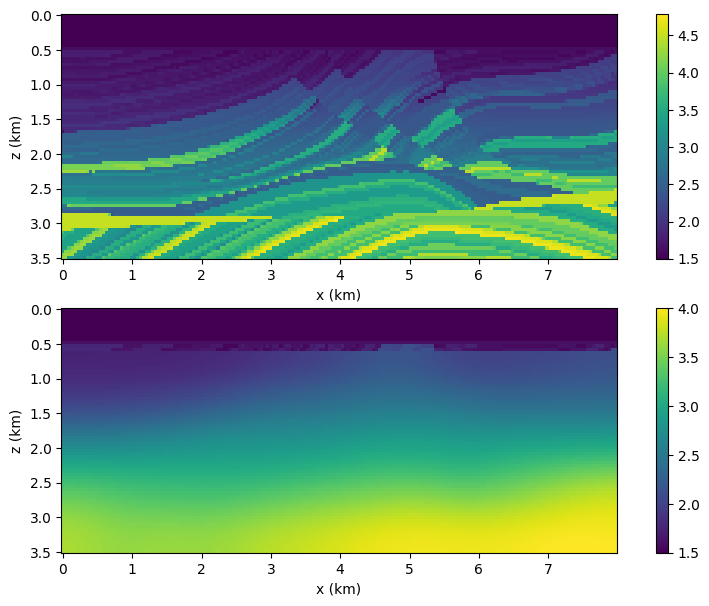

In [5]:
plt.figure(figsize=(10,7))
plt.subplot(211)
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=1)

plt.subplot(212)
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vp'].T/1e3)
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=1)

plt.show()

In [6]:
v = smooth_model['vp'].T
rho = np.power(v, 0.25) * 310
v_true = model['vp'].T
rho_true = np.power(v_true, 0.25) * 310

In [7]:
#######################################
#             子波设置
#######################################
model_true = json.load(open(os.path.join(save_path,"model/model_true.json")))
model_true = dictToObj(model_true)

#Source wavelet
tlist = list2numpy(model_true.stf_t)
st = list2numpy(model_true.stf_val)
st = st.astype(np.float32)

#######################################
#              吸收边界设置
#######################################
#PML coefficient
vmin = v_true.min()
vmax = v_true.max()
damp_global = set_damp(vmax,nx_pml,ny_pml,pml,dx)

#######################################
#              炮和检波器设置
#######################################
# Source location
src_x = list2numpy(model_true.src_x)
src_y = list2numpy(model_true.src_y)
src_n = model_true.src_n
#Receiver location
rcv_x = list2numpy(model_true.rcv_x)
rcv_y = list2numpy(model_true.rcv_y)
rcv_n = model_true.rcv_n

In [8]:
#######################################
#              参数整理
#######################################
# modeling parameters
param = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
    "vmax":vmax,"vmin":vmin
}
param = dictToObj(param)

# velocity model
vel_model ={
    "v":v,
    "rho":rho,
    "damp_global":damp_global
}
vel_model= dictToObj(vel_model)

# source
acoustic_src = {
    "src_x":src_x,
    "src_y":src_y,
    "src_n":src_n,
    "stf_val":st,
    "stf_t":tlist
}
acoustic_src = dictToObj(acoustic_src)

# receiver
acoustic_rcv = {
    'rcv_x':rcv_x,
    'rcv_y':rcv_y,
    'rcv_n':rcv_n
}
acoustic_rcv = dictToObj(acoustic_rcv)


In [9]:
import json 
param_save = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
}
model_save={
    "v":numpy2list(v),
    "rho":numpy2list(rho),
    "damp_global":numpy2list(damp_global),
    "src_x":numpy2list(src_x),
    "src_y":numpy2list(src_y),
    "src_n":src_n,
    "stf_val":numpy2list(st),
    "stf_t":numpy2list(tlist),
    'rcv_x':numpy2list(rcv_x),
    'rcv_y':numpy2list(rcv_y),
    'rcv_n':rcv_n
}
with open(os.path.join(save_path,"model/param_init.json"),'w') as f:
    json.dump(param_save,f)
with open(os.path.join(save_path,"model/model_init.json"),'w') as f:
    json.dump(model_save,f)


# np.savetxt(os.path.join(save_path,"model/v_true.txt"),v_true)
# np.savetxt(os.path.join(save_path,"model/rho_true.txt"),rho_true)
# np.savetxt(os.path.join(save_path,"model/v_init.txt"),v)
# np.savetxt(os.path.join(save_path,"model/rho_init.txt"),rho)
# rcv = np.vstack((rcv_x,rcv_y))*dx
# src = np.vstack((src_x-pml,src_y-pml))*dx
# np.savetxt(os.path.join(save_path,"model/rcv.txt"),rcv)
# np.savetxt(os.path.join(save_path,"model/src.txt"),src)

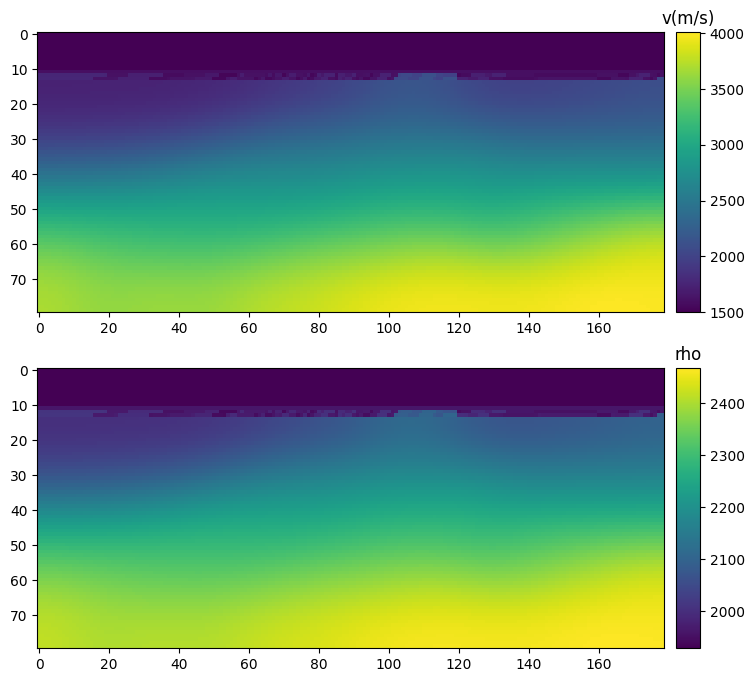

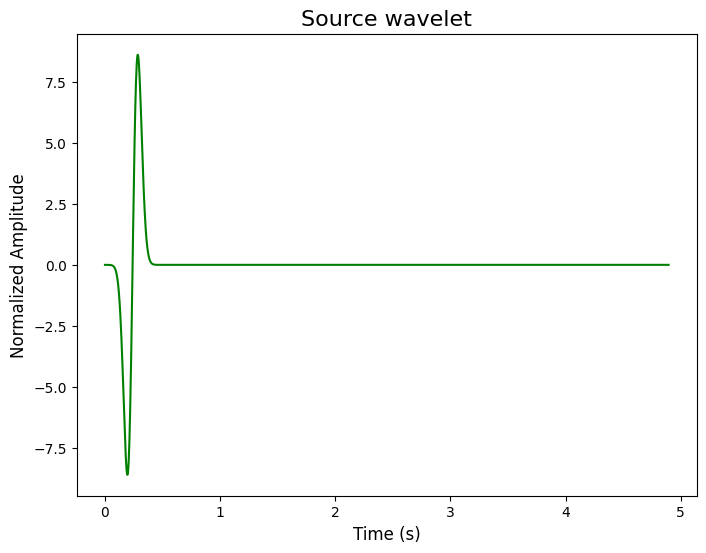

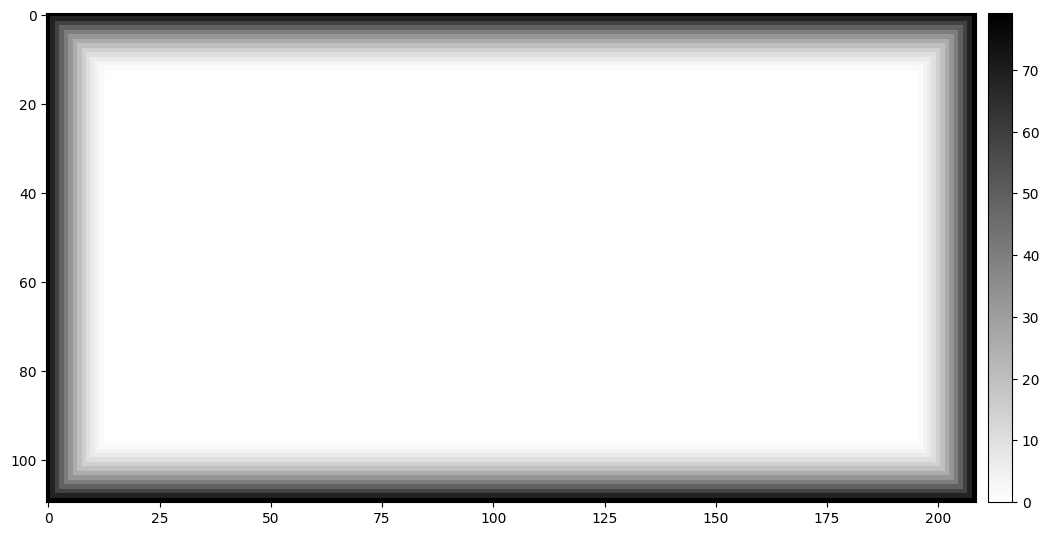

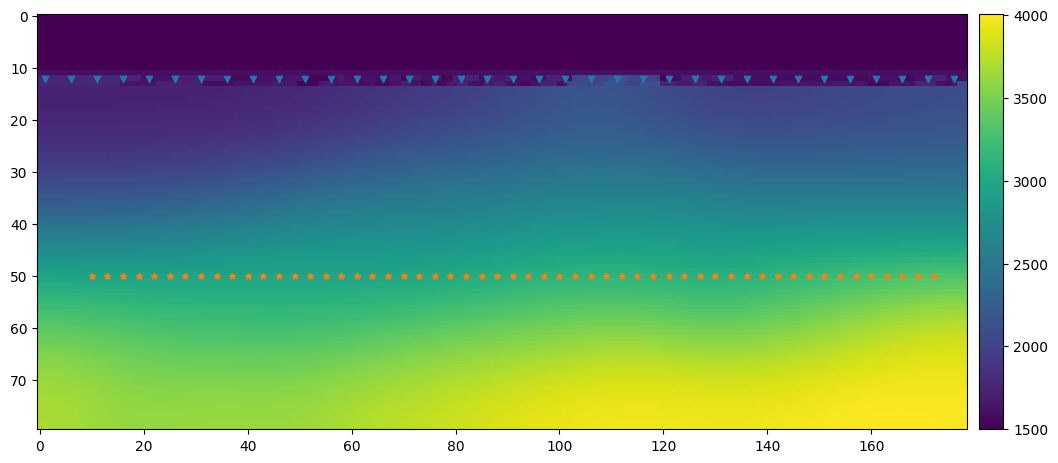

In [10]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/Initial/model_init.png"),show=True)
plot_wavelet(acoustic_src,save_path=os.path.join(save_path,"model/Initial/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/Initial/damp_global.png"),show=True)
plot_observeSystem(param,vel_model,acoustic_src,acoustic_rcv,save_path=os.path.join(save_path,"model/Initial/observed_system.png"),show=True)

In [11]:
grad_param = {
    "grad_mute":0,
    "grad_smooth":0,
    "marine_or_land":"land",
}
grad_param = dictToObj(grad_param)

In [12]:
#######################################
#         Gradient Calculation
#######################################
device = "cuda:0"
obs_data = np.load(os.path.join(save_path,"obs/obs.npz"))["obs_data"]
acoustic_sim = Acoustic_Simulation(param,vel_model,acoustic_src,acoustic_rcv,obs_data=obs_data,device=device)
# input model
rho = numpy2tensor(rho).to(device)
v = numpy2tensor(v).to(device)
v.requires_grad = True
loss,grads,csg,forw = acoustic_sim.inversion(v,rho)

# save the result
if device == 'cpu':
    loss = loss.numpy().tolist()
    # the observed 
    csg = csg.numpy()
    v = v.detach().numpy()
    rho = rho.detach().numpy()
    # the forward wavefield illumination
    forw = forw.numpy()
    grads = -grads.numpy()/2
    grads[:12,:] = 0
    grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)
else:
    loss = loss.cpu().numpy().tolist()
    csg = csg.numpy()
    v = v.cpu().detach().numpy()
    rho = rho.cpu().detach().numpy()
    # the forward wavefield illumination
    forw = forw.cpu().numpy()
    grads = -grads.cpu().numpy()/2
    grads[:12,:] = 0
    grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)


# save the observed res
np.savez(os.path.join(save_path,"syn/syn.npz"),obs_data = csg)
np.savetxt(os.path.join(save_path,"grad/grad.txt"),grads)
loss

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 1.71 GiB already allocated; 56.44 MiB free; 1.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

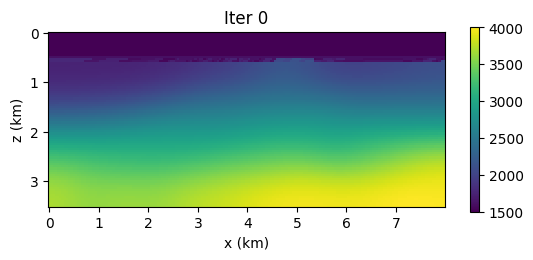

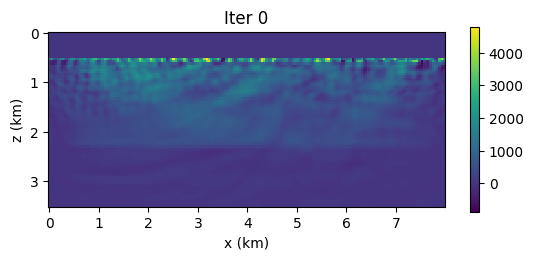

In [ ]:
# 保存图片
plt.figure()
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, v)
plt.title("Iter 0")
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(save_path,"inv/model/{}.png".format(0)),bbox_inches="tight")
plt.show()

plt.figure()
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, grads)
plt.title("Iter 0")
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(save_path,"inv/grad/{}.png".format(0)),bbox_inches="tight")
plt.show()

In [14]:
# 迭代反演
iteration = 500
loss_lists = [loss]

# optimizer
optim = Optimization(niter_max=iteration,conv=1e-8,method='SD',debug=False)
optim.nls_max = 30
optim.alpha = 0.1
grad_pre = grads

pbar = tqdm(range(1,iteration+1),position=0)
for i in pbar:
    # update the velocity
    v = optim.iterate(v,loss,grads,grad_pre)
    v = np.clip(v,a_min=vmin,a_max=vmax)
    v = v.reshape(nx,ny)
    # update the density
    rho = np.power(v, 0.25) * 310
    if(optim.FLAG == 'GRAD'):
        # recalculate the gradient
        rho = numpy2tensor(rho).to(device)
        v = numpy2tensor(v).to(device)
        v.requires_grad = True
        loss,grads,_,forw = acoustic_sim.inversion(v,rho)
        
        # save the result
        if device == 'cpu':
            v = v.detach().numpy()
            forw = forw.numpy()
            loss = loss.numpy()
            grads = -grads.numpy()/2
            grads[:12,:] = 0
            # grads = grads/v
            grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)
        else:
            v = v.cpu().detach().numpy()
            forw = forw.numpy()
            loss = loss.cpu().numpy()
            grads = -grads.cpu().numpy()/2
            grads[:12,:] = 0
            # grads = grads/v
            grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)

        # save the last grad
        grad_pre = grads.copy()
        loss_lists.append(loss)
    
    if i%1==0:
        plt.figure()
        plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, v)
        plt.title("Iter {}".format(i))
        plt.xlabel("x (km)")
        plt.ylabel("z (km)")
        plt.gca().invert_yaxis()
        plt.axis('scaled')
        plt.colorbar(shrink=0.5)
        plt.savefig(os.path.join(save_path,"inv/model/{}.png".format(i)),bbox_inches="tight")
        plt.close()
        
        plt.figure()
        plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, grads)
        plt.title("Iter {}".format(i))
        plt.xlabel("x (km)")
        plt.ylabel("z (km)")
        plt.gca().invert_yaxis()
        plt.axis('scaled')
        plt.colorbar(shrink=0.5)
        plt.savefig(os.path.join(save_path,"inv/grad/{}.png".format(i)),bbox_inches="tight")
        plt.close()
    pbar.set_description("Iter:{},Loss:{}".format(i,loss))

Iter:428,Loss:280.97369384765625:  86%|████████▌ | 428/500 [38:31<05:42,  4.76s/it]

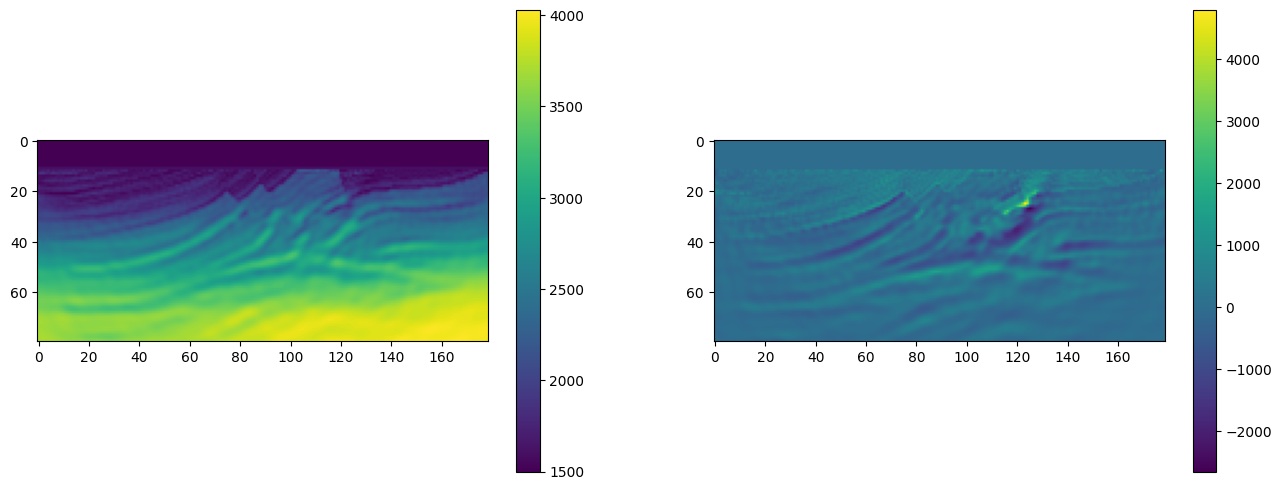

In [15]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(v)
plt.colorbar()

plt.subplot(122)
plt.imshow(grads)
plt.colorbar()
plt.show()